In [ ]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, Input, UpSampling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [ ]:
!unzip dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train/pa/pa_original_pa30.mine3.r5.png_2aa0ead9-028e-47f4-8703-89af0eeb1488.png  
  inflating: train/pa/pa_original_pa30.mine3.r5.png_64e22aa1-11b4-4fba-8f53-9c1108d35c3c.png  
  inflating: train/pa/pa_original_pa30.mine3.r5.png_79b2b461-15bb-42d8-94fa-9ab7ae3c70ef.png  
  inflating: train/pa/pa_original_pa30.mine3.r5.png_dc4c576a-82ec-425a-9923-66442709582b.png  
  inflating: train/pa/pa_original_pa30.mine3.rm10.png_64511de8-6e01-4e99-b2b7-ad3f7a037be8.png  
  inflating: train/pa/pa_original_pa30.mine3.rm10.png_6d759676-bba4-4c7b-9e2a-ae727f618532.png  
  inflating: train/pa/pa_original_pa30.mine3.rm10.png_fb67e1e0-83bc-4de0-8c94-8c7a6eb4d142.png  
  inflating: train/pa/pa_original_pa30.mine3.rm5.png_84dc00dc-57ca-4057-9691-edf1adb35819.png  
  inflating: train/pa/pa_original_pa30.mine3.rm5.png_bafe9a10-c835-4934-a2ef-e4fcc27b40b6.png  
  inflating: train/pa/pa_original_pa31.mine.b.png_1466fa72-f6b3-44a8-9f83-b284

In [ ]:
train_dir = '/content/train'
val_dir = '/content/val'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Generator data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8400 images belonging to 20 classes.
Found 2400 images belonging to 20 classes.


In [ ]:
labels = train_generator.class_indices
print(labels)

{'ba': 0, 'ca': 1, 'da': 2, 'dha': 3, 'ga': 4, 'ha': 5, 'ja': 6, 'ka': 7, 'la': 8, 'ma': 9, 'na': 10, 'nga': 11, 'nya': 12, 'pa': 13, 'ra': 14, 'sa': 15, 'ta': 16, 'tha': 17, 'wa': 18, 'ya': 19}


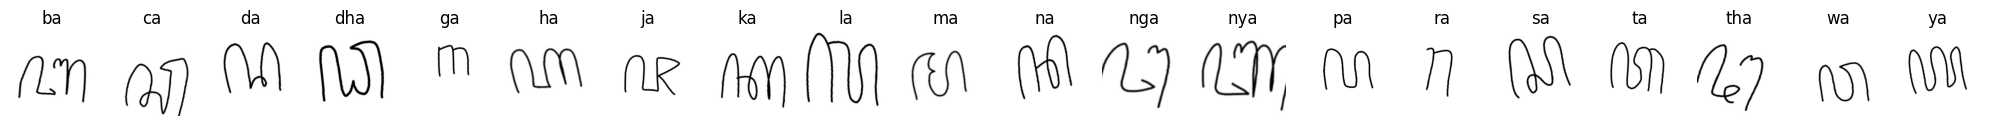

In [ ]:
def plot_gambar_asli(data_dir, labels):
    num_classes = len(labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 20))
    axes = axes.flatten()

    for idx, (class_name, class_index) in enumerate(labels.items()):
        image_dir = os.path.join(data_dir, class_name)
        image_path = os.path.join(image_dir, os.listdir(image_dir)[1])
        image = plt.imread(image_path)

        axes[idx].imshow(image)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_gambar_asli(train_dir, labels)

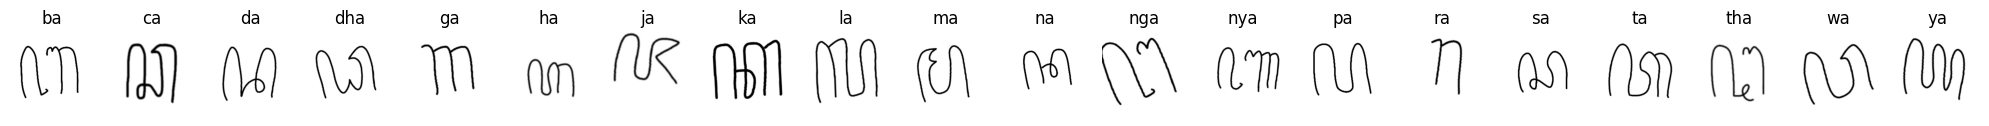

In [ ]:
def plot_gambar_asli(data_dir, labels):
    num_classes = len(labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 20))
    axes = axes.flatten()

    for idx, (class_name, class_index) in enumerate(labels.items()):
        image_dir = os.path.join(data_dir, class_name)
        image_path = os.path.join(image_dir, os.listdir(image_dir)[1])
        image = plt.imread(image_path)

        axes[idx].imshow(image)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_gambar_asli(val_dir, labels)

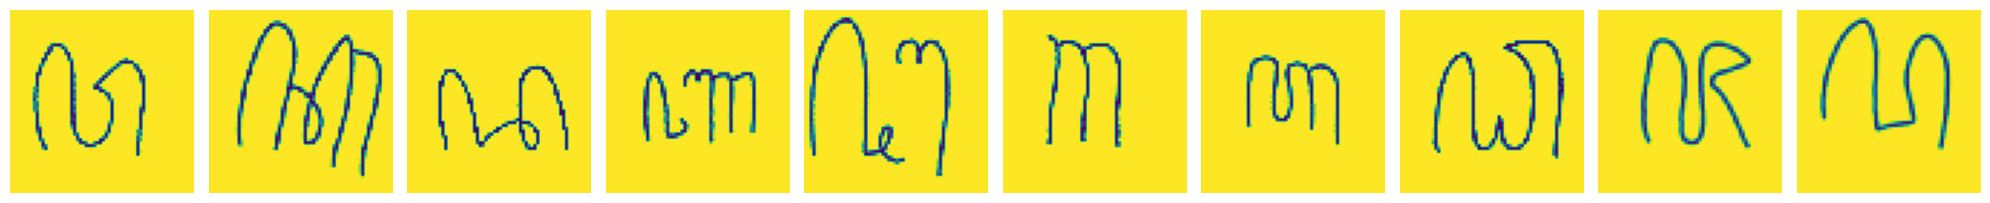

In [ ]:
def plot_gambar_augmentasi(generator):
    x_batch, y_batch = next(generator)

    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()

    for img, ax in zip(x_batch, axes):
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_gambar_augmentasi(train_generator)

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.96 and logs.get('val_accuracy') >= 0.96:
            print("\nTraining stopped as accuracy and val_accuracy have reached 96% and 96%")
            self.model.stop_training = True

In [ ]:
callback = CustomCallback()

In [ ]:
def create_cnn(input_shape=(64, 64, 1), num_classes=20):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

cnn = create_cnn()

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [ ]:
history_cnn = cnn.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callback]
)

Epoch 1/50
263/263 [==============================] - 75s 276ms/step - loss: 2.9800 - accuracy: 0.0571 - val_loss: 2.6426 - val_accuracy: 0.3246
Epoch 2/50
263/263 [==============================] - 72s 275ms/step - loss: 1.8899 - accuracy: 0.4015 - val_loss: 1.0425 - val_accuracy: 0.7038
Epoch 3/50
263/263 [==============================] - 72s 273ms/step - loss: 1.0881 - accuracy: 0.6415 - val_loss: 0.7157 - val_accuracy: 0.7825
Epoch 4/50
263/263 [==============================] - 72s 275ms/step - loss: 0.7630 - accuracy: 0.7507 - val_loss: 0.5014 - val_accuracy: 0.8642
Epoch 5/50
263/263 [==============================] - 74s 282ms/step - loss: 0.5667 - accuracy: 0.8162 - val_loss: 0.4863 - val_accuracy: 0.8833
Epoch 6/50
263/263 [==============================] - 70s 264ms/step - loss: 0.4394 - accuracy: 0.8607 - val_loss: 0.3819 - val_accuracy: 0.8900
Epoch 7/50
263/263 [==============================] - 69s 261ms/step - loss: 0.3646 - accuracy: 0.8782 - val_loss: 0.3272 - val_ac

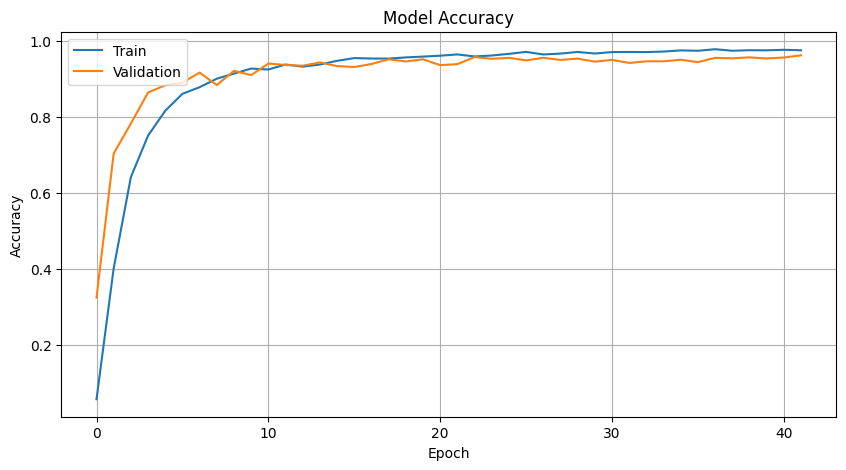

In [24]:
history = history_cnn.history

# Plotting training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

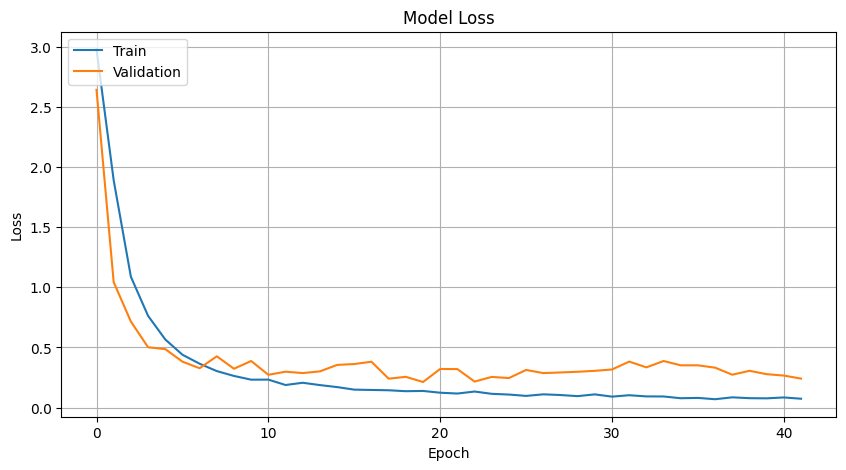

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

Saving ma_original_ma94.mine3.b.png_2e64a2c8-686f-4830-ad11-519ae4e9caba.png to ma_original_ma94.mine3.b.png_2e64a2c8-686f-4830-ad11-519ae4e9caba.png
Saving ma_original_ma94.mine3.b.png_4f1982b3-5d4d-4632-8e54-f49e89c92497.png to ma_original_ma94.mine3.b.png_4f1982b3-5d4d-4632-8e54-f49e89c92497.png
Saving ma_original_ma94.mine3.b.png_258af634-f99b-4181-ad97-c465b5a44263.png to ma_original_ma94.mine3.b.png_258af634-f99b-4181-ad97-c465b5a44263.png
Saving ma_original_ma94.mine3.png_4a5f1aba-a141-4880-8d99-9646406c04e0.png to ma_original_ma94.mine3.png_4a5f1aba-a141-4880-8d99-9646406c04e0.png
Saving ma_original_ma94.mine3.png_200b6e0c-2581-4536-a2cd-48a7030092b1.png to ma_original_ma94.mine3.png_200b6e0c-2581-4536-a2cd-48a7030092b1.png
Saving ma_original_ma94.mine3.r5.png_81bd358d-4c66-4b92-a62b-a1d9dfbfb8c8.png to ma_original_ma94.mine3.r5.png_81bd358d-4c66-4b92-a62b-a1d9dfbfb8c8.png
Saving ma_original_ma94.mine3.r5.png_23009ede-6f66-4a98-b423-549f9c423209.png to ma_original_ma94.mine3.r5

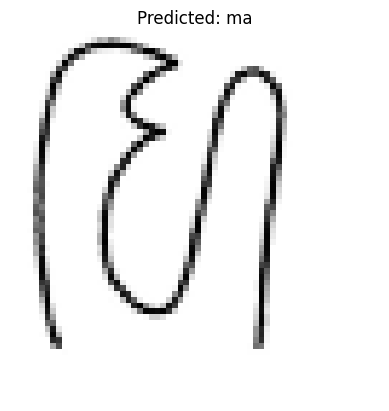

ma_original_ma94.mine3.b.png_2e64a2c8-686f-4830-ad11-519ae4e9caba.png
ma
1/1 [==============================] - 0s 27ms/step


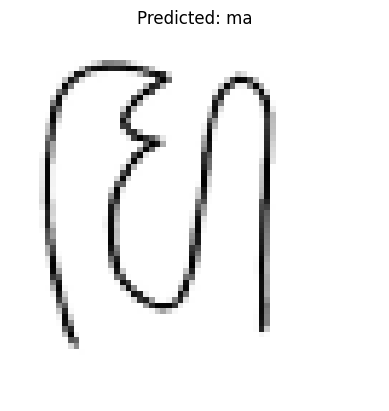

ma_original_ma94.mine3.b.png_4f1982b3-5d4d-4632-8e54-f49e89c92497.png
ma
1/1 [==============================] - 0s 24ms/step


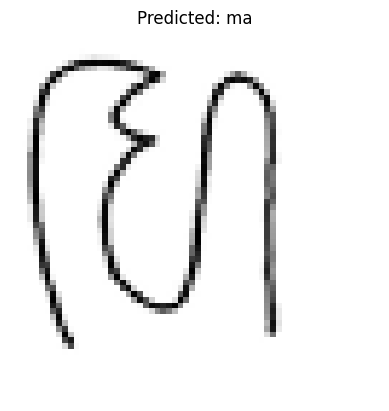

ma_original_ma94.mine3.b.png_258af634-f99b-4181-ad97-c465b5a44263.png
ma
1/1 [==============================] - 0s 42ms/step


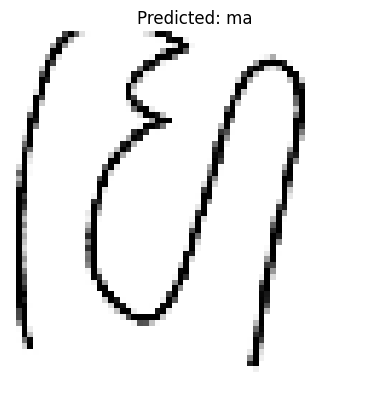

ma_original_ma94.mine3.png_4a5f1aba-a141-4880-8d99-9646406c04e0.png
ma
1/1 [==============================] - 0s 25ms/step


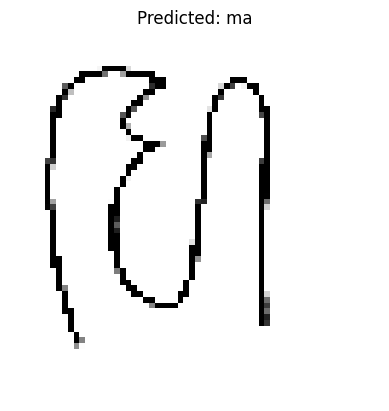

ma_original_ma94.mine3.png_200b6e0c-2581-4536-a2cd-48a7030092b1.png
ma
1/1 [==============================] - 0s 27ms/step


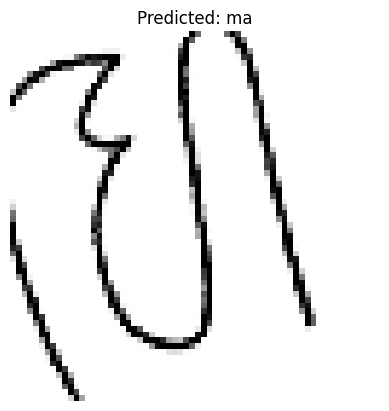

ma_original_ma94.mine3.r5.png_81bd358d-4c66-4b92-a62b-a1d9dfbfb8c8.png
ma
1/1 [==============================] - 0s 23ms/step


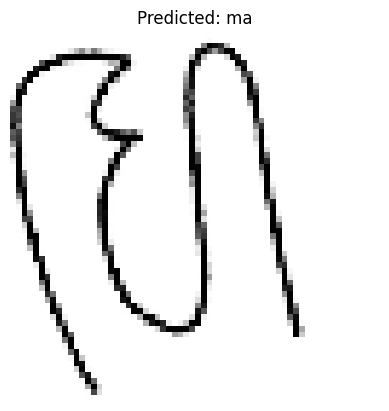

ma_original_ma94.mine3.r5.png_23009ede-6f66-4a98-b423-549f9c423209.png
ma
1/1 [==============================] - 0s 34ms/step


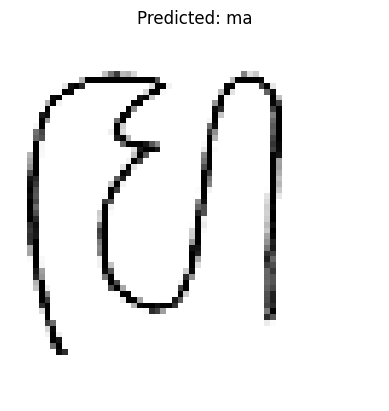

ma_original_ma94.mine3.r5.png_55142480-4ce6-42a2-a048-c8f7538ba6e8.png
ma


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

# Define the class labels
class_labels = {0: 'ba', 1: 'ca', 2: 'da', 3: 'dha', 4: 'ga', 5: 'ha', 6: 'ja', 7: 'ka', 8: 'la', 9: 'ma',
                10: 'na', 11: 'nga', 12: 'nya', 13: 'pa', 14: 'ra', 15: 'sa', 16: 'ta', 17: 'tha', 18: 'wa', 19: 'ya'}

# Upload images
uploaded = files.upload()

# Iterate over the uploaded files
for fn in uploaded.keys():
    # Load and preprocess the image
    path = fn
    img = image.load_img(path, target_size=(64, 64), color_mode='grayscale')  # Convert to grayscale
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Stack images
    images = np.vstack([x])

    # Predict the class of the image
    classes = cnn.predict(images, batch_size=10)

    # Get the index of the predicted class
    predicted_class_index = np.argmax(classes, axis=1)[0]

    # Get the class label
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image and the predicted label
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')
    plt.show()

    print(fn)
    print(predicted_class_label)

Saving ja_original_ja91.mine3.b.png_b01967bb-0bde-478f-8602-99a264fbcbd9.png to ja_original_ja91.mine3.b.png_b01967bb-0bde-478f-8602-99a264fbcbd9.png
Saving wa_original_wa9.mine.r5.png_3fcea75b-6111-4654-bfab-145038c9c2f5.png to wa_original_wa9.mine.r5.png_3fcea75b-6111-4654-bfab-145038c9c2f5.png
1/1 [==============================] - 0s 23ms/step


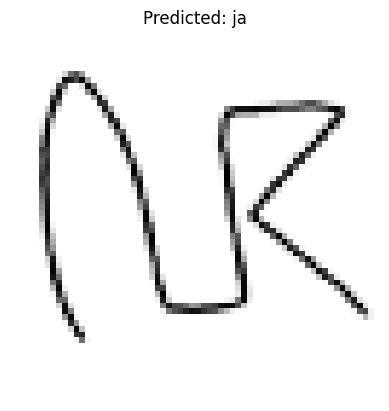

ja_original_ja91.mine3.b.png_b01967bb-0bde-478f-8602-99a264fbcbd9.png
ja
1/1 [==============================] - 0s 26ms/step


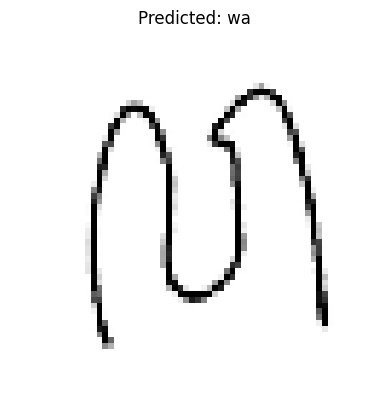

wa_original_wa9.mine.r5.png_3fcea75b-6111-4654-bfab-145038c9c2f5.png
wa


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

# Define the class labels
class_labels = {0: 'ba', 1: 'ca', 2: 'da', 3: 'dha', 4: 'ga', 5: 'ha', 6: 'ja', 7: 'ka', 8: 'la', 9: 'ma',
                10: 'na', 11: 'nga', 12: 'nya', 13: 'pa', 14: 'ra', 15: 'sa', 16: 'ta', 17: 'tha', 18: 'wa', 19: 'ya'}

# Upload images
uploaded = files.upload()

# Iterate over the uploaded files
for fn in uploaded.keys():
    # Load and preprocess the image
    path = fn
    img = image.load_img(path, target_size=(64, 64), color_mode='grayscale')  # Convert to grayscale
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Stack images
    images = np.vstack([x])

    # Predict the class of the image
    classes = cnn.predict(images, batch_size=10)

    # Get the index of the predicted class
    predicted_class_index = np.argmax(classes, axis=1)[0]

    # Get the class label
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image and the predicted label
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')
    plt.show()

    print(fn)
    print(predicted_class_label)